In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [2]:
custom_colors1 = plt.cycler(color=["#0076fd","#008239","#38DAF2","#96ED89"])
custom_colors2 = plt.cycler(color=["#0076fd","#008239","#1BBC9B"])

sns.set(rc={'axes.facecolor':'#F3F7F7','grid.alpha':0.3,'grid.color':'grey',
           'font.family':'monospace','font.weight':'semibold','figure.frameon':False,'mathtext.default':'bf',
           'legend.framealpha':1,'legend.shadow':True})
plt.rcParams["axes.prop_cycle"] = custom_colors1
plt.rcParams.keys()

C:\Users\user\Anaconda3\lib\_collections_abc.py:705: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  return '{0.__class__.__name__}({0._mapping!r})'.format(self)


KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': 'white',
          'axes.facecolor': '#F3F7F7',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

In [3]:
#Declaring the variables and constants used

#acceleration due to gravity ms^-2
g = 9.81

#water vapour-air diffusivity m^2s^-1
def D(T):
    return(2.2014*(10**-5)*(T/273.15)**1.75)

#thermal conductivity Wm^-1K^-1
def k(T):
    return(2.646*(10**-3)*(T/(1+(245.4/T)*(10**(-12/T)))**0.5))

#viscosity kgm^-1s^-1
def etta(T):
    return(1.7165*(10**-5)*(390/(T+117))*(T/273)**1.5)

#latent heat kJkg^-1
def L(T):
    T -= 273
    return(2477.9-(2.416*(T-10)))

#specific heat of air Jkg^-1K^-1
c_pa = 995
#specific hear of water vapour Jkg^-1K^-1
c_pv = 1890
#density of air kgm^-3
rho_a = 1.225
#density of water vapour kgm^-3
rho_v = 0.013

#sarurated water vapour pressure at 283K mb
p_ve283 = 12.27

#sarurated water vapour pressure mb
def p_ve(T):
    return(p_ve283 * np.exp((-6844.48*(1/T - 1/283))-(5.1704*np.log(T/283))))

#equilibrium water vapour density kgm^-3
def rho_ve(T):
    return((0.2165*p_ve(T))/T)

#total air + titak water vapour density kgm^-3
def rho(T):
    return((353.13-0.1321*p_ve(T))/T)

#specific heat of the mixture
def c_p(T):
    return(((rho_a*c_pa)+(rho_v*c_pv))/rho(T))

#vapour concentration
def c(T):
    return(rho_v/rho(T))

#vapour equilibrium concentration
def c_ve(T):
    return(rho_ve(T)/rho(T))

#temperature derivative of the saturated water vapour pressure
def p_ve_d(T):
    return(p_ve(T)*((6844.5/(T**2))-(5.1704)/T))

#temperature derivative of c_ve
def c_ve_d(T):
    return(((0.2165*p_ve_d(T)*T)-(0.2165*p_ve(T)))/(rho(T)*(T**2)))


# Vapour Mass Flux

This was modelled according to the paper in order to simulate the mass of water vapour that condenses per unit area per time, given various combinations of lower and upper boundary temperatures. The lower (hot) boundary temperature $T_0$ is the temperature of the water that flows beneath the floor of the room in order to warm it, while the upper (cold) boundary temperature $T_1$ is that of the water flowing in the ceiling to cool it down.

The model takes into account the condensation numbers of the two surfaces $Cn_0$ and $Cn_1$. These give the  ratio of the rate of heat transport by conduction to the rate of latent heat transport by vapour diffusion on each surface. Condensation number is dependent on the saturation of value of water vapour. Lower saturation gives a greater condensation number and vice versa. Each of the two surfaces is modelled to either have minimum vapour saturation (S=1) or maximum vapour saturatoin ($S_{max}$), giving the simulation the flexibility of choosing between four possible limiting cases.

In order to build a functioning simulation, the temperature of the central region in the room was taken to be a constant equal to the average temperature of the two boundary surfaces. This is true when there is no vapour concentration. In reality, as vapour concentration increases, the central region temperature varies based on a series of equations that are difficult to solve analytically, but taking the temperature as contant still gives a very good approximation of the actual process.

Given that the condensation number is much smaller than 1 for most of the temperature range between $5^\circ C$ and $85^\circ C$, the transport of latent heat governs the vapour condensation. At the ceiling, a low temperature and larger condensation number is required to ensure sufficient condensation on aerosols in the room.

In [4]:
#calculating the vapour mass flux

#temperature of the well-mixed region *C
def T_m(T_0,T_1):
    return(0.5*(T_0+T_1))

#heat transfer coefficient
def h01(T_0,T_1):
    T_0-=273
    T_1-=273
    return(0.15*((g*(T_0-T_1)*((rho(T_m(T_0,T_1)))**2)*c_p(T_m(T_0,T_1)))/(T_m(T_0,T_1)*k(T_m(T_0,T_1))*etta(T_m(T_0,T_1))))**(1/3))

def xi(T):
    return(T-273+(L(T)*c(T))/c_p(T))
    
#total heat transfer
def qt(T_0,T_1):
    return(h01(T_0,T_1)*(xi(T_0)-xi(T_1)))

#ratio of mass current to heat current
def deltaT(Ta,Tb):
    return((Ta-Tb)/(np.log(1-c_ve(Tb))-np.log(1-c_ve(Ta))))

#condensation number for maximum saturation
def cn_smax(Ta,Tb):
    return((k(Ta)*deltaT(Ta,Tb))/(L(Ta)*D(Ta)*rho(Ta)))

#condensation number for minimum saturation
def cn_s1(T):
    return((k(T)*(1-c_ve(T)))/(L(T)*D(T)*rho(T)*c_ve_d(T)))

#vapour mass flux
def M(T_0,T_1,max_sat0,max_sat1):
    if max_sat0==True:
        Cn1 = cn_smax(T_0,T_m(T_0,T_1))
    else:
        Cn1 = cn_s1(T_0)
    if max_sat1==True:
        Cn2 = cn_smax(T_m(T_0,T_1),T_1)
    else:
        Cn2 = cn_s1(T_1)
    return(10*qt(T_0,T_1)*((1/(L(T_0)*(1+Cn1)))-(1/(L(T_1)*(1+Cn2)))))



The lower boundary temperature was kept constant at $T_0=80^\circ C$ and the vapour mass flux was investigated for varying upper boundary temperature. This was done for all four possible limiting cases: Maximum saturation on both surfaces ($S_{max}$), minimum saturation on the cold surface and maximum on the hot surface (S=1 C), minimum saturation on the hot surface and maximum on the cold surface (S=1 H) and minimum saturation on both surfaces (S=1).

As seen on the figure, changing the saturation of the hot boundary has little effect on the vapour mass flux. Alternatively, a decrease in cold boundary vapour saturation results in a large increase of vapour mass flux. Ideally, if both surfaces are at minimum saturation then the maximum vapour mass flux is achievable. But even in the case where both surfaces have maximum saturation, the resulting vapour mass flux is still sufficient for rapid water droplet growth (seen later).

Similarly, a figure using a lower boundary temperature of $T_0=70^\circ C$ was also plotted.

As the upper boundary temperature inreases, vapour mass flux decreases, since the temperature difference between the two surfaces gets smaller. The results shown are in agreement with those in the paper, having only a slight difference due to the central region temperature approximation used (Fig.5 and Fig.6). This means that the model described in the paper has been simulated accurately and thus can be used in order to investigate how water droplets grow through this process.

Realistically, a vapour mass flux of at least 0.3$gm^{-2}s^{-1}$ is possible. Given a room of about two meters in height, the vapour condensation within the room could reach the water concentration levels of atmospheric clouds within a few seconds. This would create water droplet clouds based on aerosol nuclei, which can be removed in order to decrease the aerosol content confined within the room.

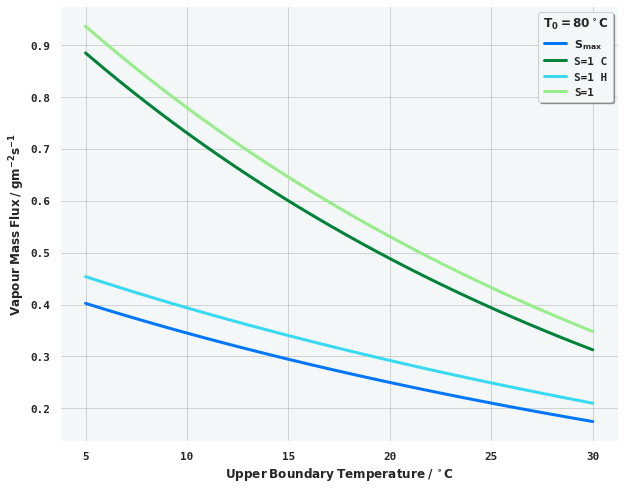

In [5]:
#recreating fig. 5 from the paper
#dependence of M on T1 at T0=80* for various saturation combinations
T0=[70,80]
T1_vals = np.linspace(5,30,100)
M_vals_s1_c= [[],[]]
M_vals_s1_h = [[],[]]

M_vals_smax = [[],[]]
for i in range(len(T0)):
    for val in T1_vals:
        M_vals_smax[i].append(M(T0[i]+273,val+273,True,True))

M_vals_s1 = [[],[]]
for i in range(len(T0)):
    for val in T1_vals:
        M_vals_s1[i].append(M(T0[i]+273,val+273,False,False))
        
for i in range(len(T0)):
    for val in T1_vals:
        M_vals_s1_c[i].append(M(T0[i]+273,val+273,False,True))
        M_vals_s1_h[i].append(M(T0[i]+273,val+273,True,False))
        
fig = plt.figure(figsize=(10,8))
plt.plot(T1_vals,M_vals_smax[1],label="$S_{max}$",lw=3)
plt.plot(T1_vals,M_vals_s1_c[1],label="S=1 C",lw=3)
plt.plot(T1_vals,M_vals_s1_h[1],label="S=1 H",lw=3)
plt.plot(T1_vals,M_vals_s1[1],label="S=1",lw=3)

plt.xlabel("$Upper\:Boundary\:Temperature\:/\:^\circ C$")
plt.ylabel("$Vapour\:Mass\:Flux\:/\:gm^{-2}s^{-1}$")
plt.legend(title="$T_0=80^\circ C$");

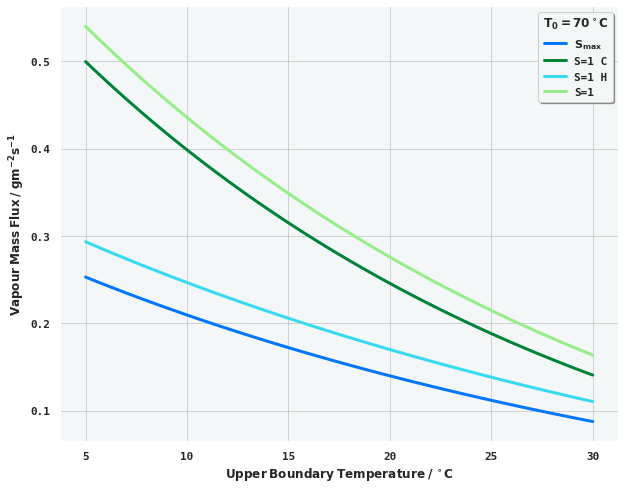

In [6]:
#recreating fig. 6 from the paper
#dependence of M on T1 at T0=70* for various saturation combinations
       
fig = plt.figure(figsize=(10,8))
plt.plot(T1_vals,M_vals_smax[0],label="$S_{max}$",lw=3)
plt.plot(T1_vals,M_vals_s1_c[0],label="S=1 C",lw=3)
plt.plot(T1_vals,M_vals_s1_h[0],label="S=1 H",lw=3)
plt.plot(T1_vals,M_vals_s1[0],label="S=1",lw=3)

plt.xlabel("$Upper\:Boundary\:Temperature\:/\:^\circ C$")
plt.ylabel("$Vapour\:Mass\:Flux\:/\:gm^{-2}s^{-1}$")
plt.legend(title="$T_0=70^\circ C$");

# Droplet Growth

Using the vapour mass flux, the growth of water droplets condensing on aerosols can be simulated for various input combinations of boundary temperatures and vapour saturations. Droplet growth also depends on the height of the room and the aerosol residence time, which needs to be sufficiently large to allow the droplets to reach a size that makes them easily removable. Another important parameter is the number density of aerosols, representing the number of aersolos per unit volume. In the simulation, this is taken to be equal to the value of typical polluted urban aerosols $10^{11}m^{-3}$.

Given the rapid growth of the droplets, the initial size of the aerosols is insignificant to the results, so it's not specified. Additionally, the droplets are modelled to be perfect spheres with a final radius in the order of μm. The room height is kept at 2m but has the flexibility of being varied depending on the situation.

In [7]:
#calculating the growth of the water droplets


#room height
h = 2

#aerosol density
N = 10**11

#final ratio of water volume to room volume
def vol_ratio(T_0,T_1,max_sat0,max_sat1,t_R):
    return(M(T_0,T_1,max_sat0,max_sat1)*t_R)

#radius of spherical water droplet μm after a specific time (T in K)
def R_f(T_0,T_1,t,max_sat0,max_sat1):
    r3 = 2.387*(M(T_0,T_1,max_sat0,max_sat1)/(h*(N/(10**11))))*t
    return(r3**(1/3))

#time for droplet to reach a given radius (T in K)
def t(T_0,T_1,Rf,max_sat0,max_sat1):
    return(((Rf**3)/2.387)*((h*((10**11)/N))/M(T_0,T_1,max_sat0,max_sat1)))

The following plot shows how much time it takes for the droplets to reach 1μm in radius with varying upper boundary temperature, keeping the lower boundary temperature at $70^\circ C$ and $80^\circ C$, for a room 2m tall. The vapour saturation is kept at maximum for both surfaces, which results in the slowest possible growth. Nevertheless, it's observed that even under these conditions, the aeorosols take only a couple of seconds to grow to the micron size, which is required in order to effectively remove them. This means that the process described in the paper could result in a rapid growth and eventually removal of aerosols under realistic room conditions.

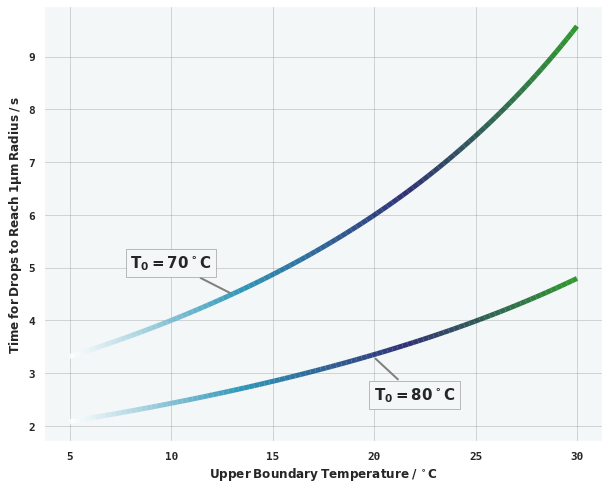

In [8]:
from matplotlib.collections import LineCollection

#plotting the growth of a water droplet to reach a micron, for different upper boundary temperatures

t_vals = [[],[]]

for i in range(len(T0)):
    for val in T1_vals:
        t_vals[i].append(t(T0[i]+273,val+273,1,True,True))
        
fig = plt.figure(figsize=(10,8))
l1 = sns.lineplot(T1_vals,t_vals[0],lw=3)
l2 = sns.lineplot(T1_vals,t_vals[1],lw=3)
axis = [l1,l2]

for ax in axis:
    x, y = ax.get_lines()[0].get_data()
    segments = np.array([x[:-1], y[:-1], x[1:], y[1:]]).T.reshape(-1, 2, 2)
    lc = LineCollection(segments, cmap='ocean_r')
    lc.set_array(x[:-1])
    lc.set_linewidth(5)
    lc.set_alpha(0.8)
    ax.get_lines()[0].remove()
    line = ax.add_collection(lc)
    
plt.annotate("$T_0=70^\circ C$",(13,4.5),xytext=(10,5),horizontalalignment="center",
             bbox=dict(boxstyle='square',facecolor='#F3F7F7',edgecolor="grey",linewidth=0.5),
             arrowprops=dict(color='grey', arrowstyle="-",linewidth=2),size=15)

plt.annotate("$T_0=80^\circ C$",(20,3.3),xytext=(22,2.5),horizontalalignment="center",
             bbox=dict(boxstyle='square',facecolor='#F3F7F7',edgecolor="grey",linewidth=0.5),
             arrowprops=dict(color='grey', arrowstyle="-",linewidth=2),size=15)

plt.xlabel("$Upper\:Boundary\:Temperature\:/\:^\circ C$")
plt.ylabel("$Time\:for\:Drops\:to\:Reach\:1μm\:Radius\:/\:s$");

Aerosol growth was simulated for three different boundary temperature combinations, assuming maximum vapour saturation on both surfaces. This was plotted in the form of droplet radius as a function of growth time. The assumption of negligible initial aerosol size was implemented, as stated previously, since it doesn't have an observable effect on the results. As seen on the plot, the droplets grow rapidly at the beginning until they reach the micron size, and then keep growing with a steady rate. The time scale can be adjusted given the maximum achievable droplet size, but in this case it's taken to be at 1μm radius. The time required to reach such a size, for all three scenarios, is also indicated.

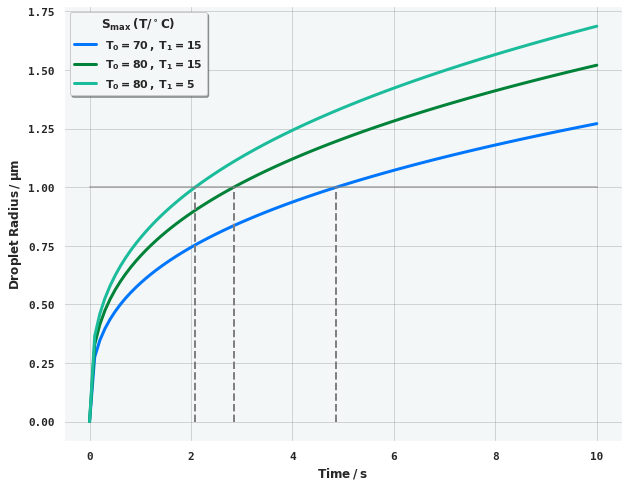

In [9]:
plt.rcParams["axes.prop_cycle"] = custom_colors2

#plotting the growth of a water droplet as a function of time for max saturation

time_vals = np.linspace(0,10,100)
temp_comps = [[70,15],[80,15],[80,5]]
radius_vals = [[],[],[]]

fig = plt.figure(figsize=(10,8))

for i in range(len(temp_comps)):
    for val in time_vals:
        radius_vals[i].append(R_f(temp_comps[i][0]+273,temp_comps[i][1]+273,val,True,True))
    plt.plot(time_vals,radius_vals[i],lw=3,label=f"$T_0={temp_comps[i][0]}\:,\:T_1={temp_comps[i][1]}$")
    t_1 = t(temp_comps[i][0]+273,temp_comps[i][1]+273,1,True,True)
    vertical_values = np.linspace(0,1,5)
    plt.plot([t_1]*len(vertical_values),vertical_values,"--",c="grey",lw=2)

plt.plot(time_vals,[1]*len(time_vals),"-",c="grey",lw=2,alpha=0.5)

plt.xlabel("$Time\:/\:s$")
plt.ylabel("$Droplet\:Radius\:/\:μm$")
plt.legend(title="$S_{max}\:(T/^\circ C)$");


The droplet growth for the same temperature combinations was also simulated for minimum saturation on the two surfaces, resulting in even smaller times for reaching 1μm radius and also larger sizes being achievable faster.

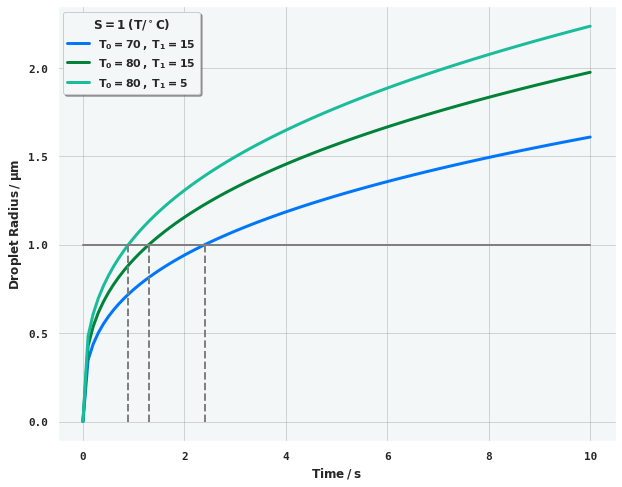

In [10]:
plt.rcParams["axes.prop_cycle"] = custom_colors2

#plotting the growth of a water droplet as a function of time for saturation = 1

time_vals = np.linspace(0,10,100)
temp_comps = [[70,15],[80,15],[80,5]]
radius_vals = [[],[],[]]

fig = plt.figure(figsize=(10,8))

for i in range(len(temp_comps)):
    for val in time_vals:
        radius_vals[i].append(R_f(temp_comps[i][0]+273,temp_comps[i][1]+273,val,False,False))
    plt.plot(time_vals,radius_vals[i],lw=3,label=f"$T_0={temp_comps[i][0]}\:,\:T_1={temp_comps[i][1]}$")
    t_1 = t(temp_comps[i][0]+273,temp_comps[i][1]+273,1,False,False)
    vertical_values = np.linspace(0,1,5)
    plt.plot([t_1]*len(vertical_values),vertical_values,"--",c="grey",lw=2)

plt.plot(time_vals,[1]*len(time_vals),"-",c="grey",lw=2)
plt.xlabel("$Time\:/\:s$")
plt.ylabel("$Droplet\:Radius\:/\:μm$")
plt.legend(title="$S=1\:(T/^\circ C)$");


Slow cooling will result in droplets evaporating on the walls of the room, an effect which can be observed in bathrooms. In order to avoid this, the removal of droplets should occur before they cool down to a final temperature, unless the cooling is quick.

The final droplet size is investigated for various aerosol number densities, at residence times $t_R=10s$ and $t_R=100s$ for a room height of 1m. These are in agreement with the values from the paper (Table 2) for a vapour mass flux of $M=0.5gm^{-2}s^{-1}$ (achieved with temperatures $T_0=70^\circ C$, $T_1=5^\circ C$ when the upper boundary has minimum saturation and the lower boundary has maximum saturation). Since there is an agreement between the simulation and the paper, there's further evidence of the accuracy of the simulated model, which can therefore be used in order to make reliable predictions in regards to the behaviour of the process described in the paper.

In [11]:
N_vals = [10**9,10**10,10**11,10**12]
N_txt = ["$10^9$","$10^{10}$","$10^{11}$","$10^{12}$"]
col_names = ["N","$R_f$ for $t_R=10\:s$","$R_f$ for $t_r=100\:s$"]
Rf_table = []
h=1
for i in range(len(N_vals)):
    N = N_vals[i]
    Rf_table.append([N_txt[i]])
    Rf_table[i].append(np.round(R_f(70+273,5+273,10,False,True),1))
    Rf_table[i].append(np.round(R_f(70+273,5+273,100,False,True),1))
    

#restores the original N value
N = N = 10**11
h=2

Rf_table = pd.DataFrame(Rf_table,columns = col_names)
Rf_table.set_index(Rf_table["N"],inplace=True)
Rf_table.pop("N")
Rf_table.head()

,$R_f$ for $t_R=10\:s$,$R_f$ for $t_r=100\:s$
N,,
$10^9$,10.6,22.8
$10^{10}$,4.9,10.6
$10^{11}$,2.3,4.9
$10^{12}$,1.1,2.3


As seen on the table above, for $t_R=100s$ the final droplet sizes reached are much more than enough for a successfull removal. Depending on the removal method, even $t_R=10s$ results in large enough droplets which can effectively be removed. For the shorter residence time, the velocities of the input and outlet flows could result in large changes to the convection pattern of air within the room and this may result in large changes to the final droplet sizes.

Realistically, a vapour mass flux of about $0.3gm^{-2}s^{-1}$ can be achieved by using $T_0 = 80^\circ C$, $T_1 = 15^\circ C$. Assuming a room of height 2m and maximum aerosol saturation on both boundaries, the final droplet radius $R_f$ can be found as a function of time for the various possible aerosol number densities N.

In [12]:
tr_vals = [1,5,10,30,50,80,100]

Rf_results = pd.DataFrame(columns=["Residence Time","Number Density","Final Radius"])

time_res = []
Rf_vals = []
N_res = []

for tr in tr_vals:
    for i in range(len(N_vals)):
        N = N_vals[i]
        time_res.append(tr)
        N_res.append(N_txt[i])
        Rf_vals.append(R_f(80+273,15+273,tr,True,True))
    
Rf_results["Residence Time"] = time_res
Rf_results["Number Density"] = N_res
Rf_results["Final Radius"] = Rf_vals


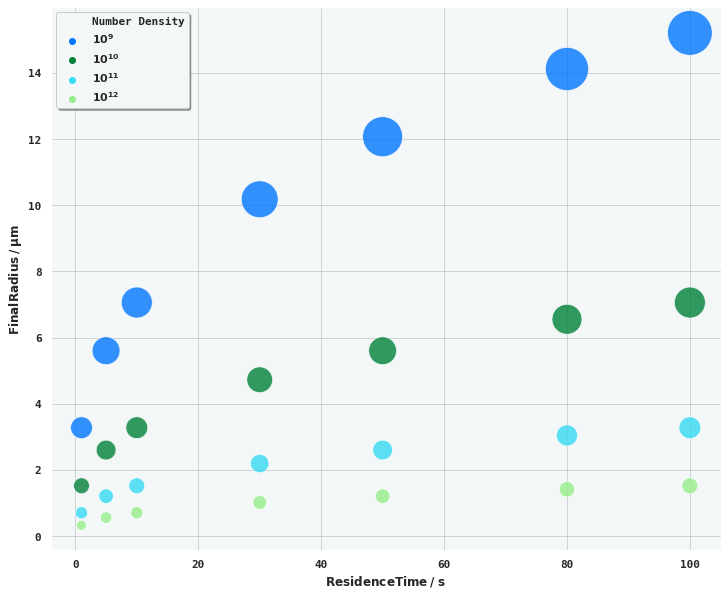

In [13]:
plt.rcParams["axes.prop_cycle"] = custom_colors1


fig = plt.figure(figsize=(12,10))

bubble_plot = sns.scatterplot("Residence Time","Final Radius",data=Rf_results,hue="Number Density",
                              size="Final Radius",sizes = (100,2000),alpha=0.8)

h,l = bubble_plot.get_legend_handles_labels()
plt.legend(h[:5],l[:5])

bubble_plot.set_xlabel("$Residence Time \:/\: s$")
bubble_plot.set_ylabel("$Final Radius\: /\:\mu m$");

As seen on the figure above, the lower the aerosol number density, the larger the droplet size. The effect of changing the aerosol density on the final radius, as time passes by, is similar to that of changing the temperature combination, shown in the previous plot. The data points scale with radius, showing the extend of the effect of aerosol densoty increase. 

### Amount of Water Required

As seen from previous graph, for particles to be above $1\mu m$ a residence time of **30s** would be sufficient.
<br>
Assuming we have a chamber of $1 m^3$, $120 m^3$ of air could be clean in **1 hour**.

 $T_0 = 80^\circ C$, $T_1 = 15^\circ C$

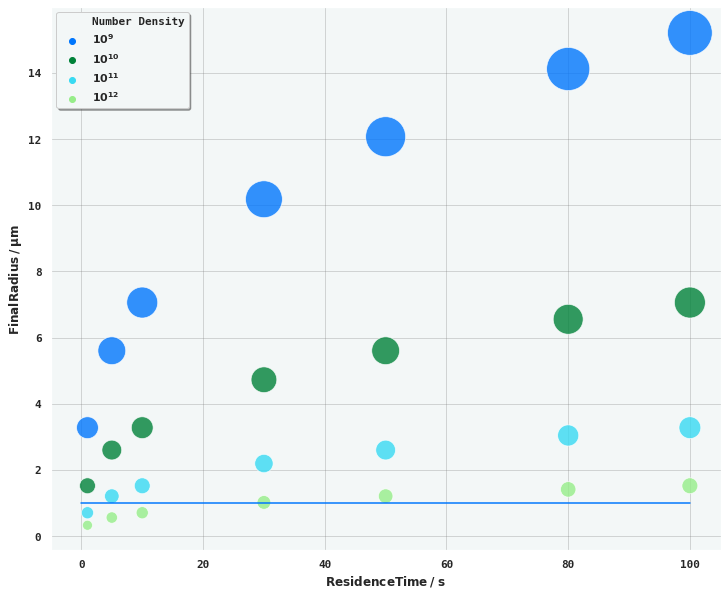

In [14]:
plt.rcParams["axes.prop_cycle"] = custom_colors1


fig = plt.figure(figsize=(12,10))

bubble_plot = sns.scatterplot("Residence Time","Final Radius",data=Rf_results,hue="Number Density",
                              size="Final Radius",sizes = (100,2000),alpha=0.8)

h,l = bubble_plot.get_legend_handles_labels()
plt.legend(h[:5],l[:5])

bubble_plot.set_xlabel("$Residence Time \:/\: s$")
bubble_plot.set_ylabel("$Final Radius\: /\:\mu m$");

plt.plot([0,100],[1,1])

In [15]:
runningt = 3600                             # run time of chamber

condensedrate = M(80+273,15+273,True,True)  # condensation rate with chosen temperature
condensed = condensedrate*runningt/1000     # water condensed on aerosol
print("Amount of water condensed on particle: {:.4f} litre".format(condensed))

Amount of water condensed on particle: 1.0607 litre


But a larger amount of water would condensed on the roof but this water, assumming the condensation rate on roof is twice the condensation of particle.

To cool roof we need running water. Assume we need 10 litres of running water to remove heat from chamber roof

The price of water is 249.03p per cubic meter

In [16]:
conroof = 2*condensedrate                          # condensation rate on roof
contotalwater = condensed + conroof*runningt/1000  # total water condensed on aerosol and roof
totalwater = contotalwater + 10                    # total amount of water needed

wcost = totalwater/1000*249.03                     # cost of water


print("Total amount of water needed: {:.4f} litre".format(totalwater))
print("Total cost of water operating chamber for 1 hour: {0:.2f}p". format(wcost))

Total amount of water needed: 13.1821 litre
Total cost of water operating chamber for 1 hour: 3.28p


### Energy required for heating

In [17]:
mwater = contotalwater     # amount of water needed to be heated
Troom = 20                 # initial temperature of water
c = 4181                   # specific heat capacity of water
COPheat = 0.95             # coefficient of performance using an electric heater

def eheat(meva, T1, T0, t):
    '''
    Equation to calculate energy required to operate chamber
    
    Input:
    meva = amount of water needed to be heat
    T1 = final temperature required
    T0 = temperature of roof
    t = running time of chamber
    
    Output:
    Energy required
    '''
    eheat = meva*c*(T1-Troom)/COPheat + conroof/1000*c*(T1-T0)*t/COPheat
    return eheat

In [18]:
totalenergy = eheat(mwater, 80, 15, runningt)           # energy required
operatingpower = totalenergy/runningt                   # power required
print("Energy required to operate chamber for 1hour: {0:.3f}kJ".format(totalenergy/1000))
print("Operating power of chamber: {0:.3f}W". format(operatingpower))

Energy required to operate chamber for 1hour: 1447.149kJ
Operating power of chamber: 401.986W


Average cost of electricity: 28p per kWh

In [19]:
eleccost = 28                                   # cost of electricity per kWh
kilowatts = operatingpower/1000*runningt/3600   # kWh
ecost = kilowatts*eleccost                      # cost of electricity
print("Cost needed for heating of water when chamber operates for 1 hour: {0:.2f} p".format(ecost))

totalcost = wcost + ecost                       # total cost
print("Total cost needed to run chamber for 1 hour: {0:.2f} p".format(totalcost))

Cost needed for heating of water when chamber operates for 1 hour: 11.26 p
Total cost needed to run chamber for 1 hour: 14.54 p


## Comparison with Experimental Group
Assume we have a chamber size of $0.1m^3$.
<br>
It would take 30s to clean $0.1m^3$ of air.

In [20]:
runningt = 30                                       # run time of chamber

condensed = condensedrate*runningt/1000             # amount of water condensed on aerosols
conroof = 2*condensedrate                           # condensation rate on roof
contotalwater = condensed + conroof*runningt/1000   # amount of water condensed on aerosols and roof
totalwater = contotalwater + 10                     # total amount of water needed

wcost = totalwater/1000*249.03                      # cost of water


print("Total amount of water needed: {:.4f} litre".format(totalwater))
print("Total cost of water operating chamber for 30s: {0:.2f}p". format(wcost))

Total amount of water needed: 10.0265 litre
Total cost of water operating chamber for 30s: 2.50p


In [21]:
mwater = contotalwater                              # amount of water required to be heated
 
totalenergy = eheat(mwater, 80, 15, runningt)       # total energy required to heat water
operatingpower = totalenergy/runningt               # power required
print("Energy required to operate chamber for 30s: {0:.3f}kJ".format(totalenergy/1000))
print("Operating power of chamber: {0:.3f}W". format(operatingpower))

Energy required to operate chamber for 30s: 12.060kJ
Operating power of chamber: 401.986W


In [22]:
kilowatts = operatingpower/1000*runningt/3600
ecost = kilowatts*eleccost
print("Cost needed for heating of water when chamber operates for 30s: {0:.2f} p".format(ecost))

totalcost = wcost + ecost
print("Total cost needed to run chamber for 30s: {0:.2f} p".format(totalcost))

Cost needed for heating of water when chamber operates for 30s: 0.09 p
Total cost needed to run chamber for 30s: 2.59 p
